### Dependencies

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [23]:
TRAIN_DF_FILEPATH = os.path.join("Data","train.csv")
TEST_DF_FILEPATH = os.path.join("Data","test.csv")
SAMPLE_SUB_DF_FILEPATH = os.path.join("Data","sample_submission.csv")

### Loading the Data

In [5]:
train_df = pd.read_csv(TRAIN_DF_FILEPATH)
train_df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [37]:
def Preprocessing(df):
    df = df.set_index(df["id"])
    df.drop(columns = ["id"],inplace = True)
    df["Sex"] = df["Sex"].map(lambda x:0 if x=="male" else 1)
    df["BMI"] = round(df["Weight"]/((df["Height"]/100)**2))
    return df

In [38]:
preprocessed_df = Preprocessing(train_df)
sample = preprocessed_df.sample(10000)
sample.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI
id,,,,,,,,,
634438,0,40,180.0,81.0,29.0,114.0,41.0,231.0,25.0
259968,1,65,178.0,75.0,18.0,95.0,40.4,98.0,24.0
225856,1,71,173.0,75.0,22.0,105.0,40.7,146.0,25.0
614448,1,34,174.0,68.0,10.0,84.0,40.0,37.0,22.0
639425,0,28,169.0,71.0,28.0,101.0,40.8,141.0,25.0


In [39]:
preprocessed_df.describe()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,0.500961,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781,24.373471
std,0.499999,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349,1.540541
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000,12.000000
25%,0.000000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000,23.000000
50%,1.000000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000,24.000000
75%,1.000000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000,25.000000
max,1.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000,46.000000


In [9]:
preprocessed_df[['Calories',"Duration","Heart_Rate","BMI","Sex","Age","Height","Weight"]].corr()

,Calories,Duration,Heart_Rate,BMI,Sex,Age,Height,Weight
Calories,1.000000,0.959908,0.908748,0.049203,-0.012011,0.145683,-0.004026,0.015863
Duration,0.959908,1.000000,0.875327,0.006111,0.009594,0.015656,-0.029936,-0.020845
Heart_Rate,0.908748,0.875327,1.000000,0.023449,-0.009122,0.017037,-0.013234,-0.002384
BMI,0.049203,0.006111,0.023449,1.000000,-0.682521,0.192318,0.522588,0.739686
Sex,-0.012011,0.009594,-0.009122,-0.682521,1.000000,-0.009689,-0.755906,-0.818250
Age,0.145683,0.015656,0.017037,0.192318,-0.009689,1.000000,0.011975,0.073690
Height,-0.004026,-0.029936,-0.013234,0.522588,-0.755906,0.011975,1.000000,0.957967
Weight,0.015863,-0.020845,-0.002384,0.739686,-0.818250,0.073690,0.957967,1.000000


### Visualising the Data

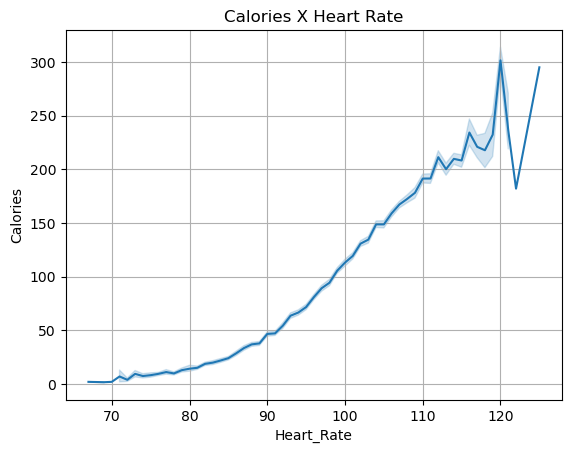

In [10]:
sns.lineplot(data = sample,x = "Heart_Rate",y = "Calories")
plt.title("Calories X Heart Rate")
plt.grid()
plt.show()

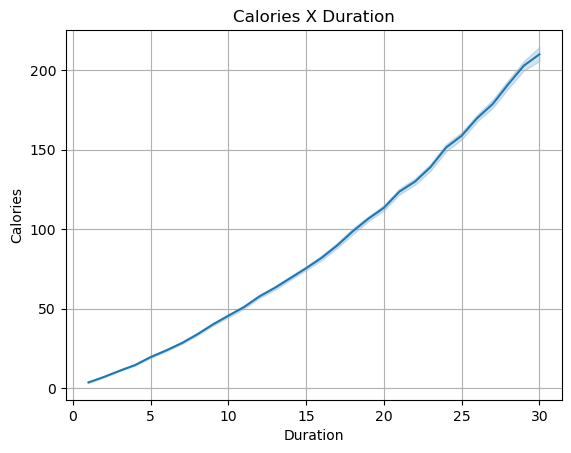

In [11]:
sns.lineplot(data = sample,x = "Duration",y = "Calories")
plt.title("Calories X Duration")
plt.grid()
plt.show()

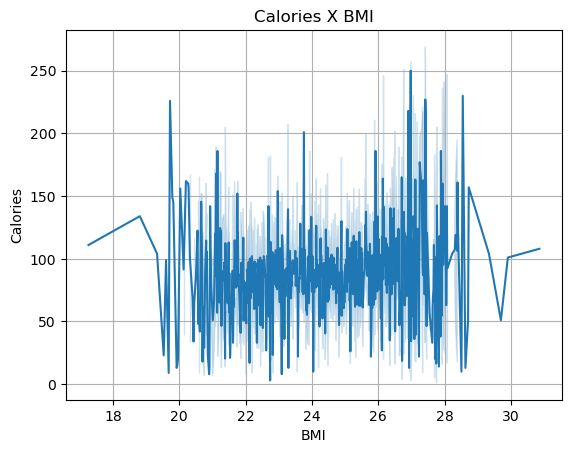

In [12]:
sns.lineplot(data = sample,x = "BMI",y = "Calories")
plt.title("Calories X BMI")
plt.grid()
plt.show()

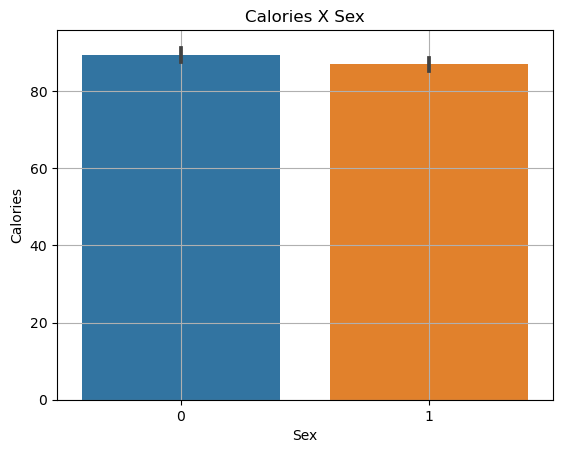

In [13]:
sns.barplot(data = sample,x="Sex",y = "Calories")
plt.title("Calories X Sex")
plt.grid()
plt.show()

### Training the model

In [40]:
X = preprocessed_df.drop(columns=["Calories"])
y = preprocessed_df["Calories"]

In [41]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=4)
print(f"X_train: {X_train.shape}")
print(f"X_train: {y_train.shape}")
print(f"X_train: {X_test.shape}")
print(f"X_train: {y_test.shape}")

X_train: (600000, 8)
X_train: (600000,)
X_train: (150000, 8)
X_train: (150000,)


In [42]:
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [43]:
scaled_X = scaler.fit_transform(X)

In [55]:
model = xgb.XGBRegressor(n_estimators = 4000,learning_rate = 0.2,max_depth = 10,random_state = 4,eval_metric = "rmse",early_stopping_rounds = 10)

set = [(scaled_X,y)]

model.fit(
    scaled_X,y,
    eval_set = set,
    verbose = 3)

[0]	validation_0-rmse:50.03896
[3]	validation_0-rmse:25.95565
[6]	validation_0-rmse:13.73595
[9]	validation_0-rmse:7.70681
[12]	validation_0-rmse:4.94650
[15]	validation_0-rmse:3.85014
[18]	validation_0-rmse:3.46587
[21]	validation_0-rmse:3.32839
[24]	validation_0-rmse:3.27127
[27]	validation_0-rmse:3.24071
[30]	validation_0-rmse:3.21875
[33]	validation_0-rmse:3.19927
[36]	validation_0-rmse:3.18180
[39]	validation_0-rmse:3.16733
[42]	validation_0-rmse:3.15659
[45]	validation_0-rmse:3.14938
[48]	validation_0-rmse:3.14079
[51]	validation_0-rmse:3.13490
[54]	validation_0-rmse:3.12215
[57]	validation_0-rmse:3.11594
[60]	validation_0-rmse:3.10882
[63]	validation_0-rmse:3.10486
[66]	validation_0-rmse:3.09659
[69]	validation_0-rmse:3.08262
[72]	validation_0-rmse:3.07692
[75]	validation_0-rmse:3.06865
[78]	validation_0-rmse:3.06315
[81]	validation_0-rmse:3.05731
[84]	validation_0-rmse:3.04706
[87]	validation_0-rmse:3.03533
[90]	validation_0-rmse:3.02603
[93]	validation_0-rmse:3.01707
[96]	vali

KeyboardInterrupt: 

In [49]:
test_df = pd.read_csv(TEST_DF_FILEPATH)
preprocessed_test_df = Preprocessing(test_df)
preprocessed_test_df.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI
id,,,,,,,,
750000,0,45,177.0,81.0,7.0,87.0,39.8,26.0
750001,0,26,200.0,97.0,20.0,101.0,40.5,24.0
750002,1,29,188.0,85.0,16.0,102.0,40.4,24.0
750003,1,39,172.0,73.0,20.0,107.0,40.6,25.0
750004,1,30,173.0,67.0,16.0,94.0,40.5,22.0


In [50]:
scaled_test = scaler.transform(preprocessed_test_df)

In [52]:
yhat = model.predict(scaled_test)
sub = pd.read_csv(SAMPLE_SUB_DF_FILEPATH)
sub["Calories"] = yhat
sub.to_csv(os.path.join("SubmissionData","model-v2.csv"),index=False)
sub.head()

,id,Calories
0,750000,27.293049
1,750001,108.347336
2,750002,86.396461
3,750003,124.533325
4,750004,76.677170


In [54]:
sub.describe()

,id,Calories
count,250000.000000,250000.000000
mean,874999.500000,88.252861
std,72168.927986,62.323746
min,750000.000000,-0.006864
25%,812499.750000,34.090547
50%,874999.500000,76.496506
75%,937499.250000,135.447670
max,999999.000000,305.582703
